# Fundamentals of Computer Vision

This Jupyter Notebook covers **Project 3** of the course and focuses on implementing Harris Corner Detector and LoG Blob Detector to introduce fundamental concepts in image processing. Each section has questions that must be answered in a Document in PDF format.

**Important**

Both the Harris Corner Detector and LoG Blob Detector tasks (Code + Answers) must be submitted; otherwise, your work will be rejected.


## Grading Breakdown: ##
- Harris Corner Detector: 50 points (Code: 30 pts, Answers: 20 pts).
- LoG Blob Detector: 50 points (Code: 30 pts, Answers: 20 pts).

To pass Project 3, a minimum of **50 points** is required.

# **Feature Extraction**

## **Harris Corner Detector**

In this exercise, you will implement the Harris corner detection algorithm to identify corner features in images. Follow these steps to complete the implementation of the `harris_corner_detection()` function:

1. Convert to Grayscale: Convert the input image to grayscale with floating-point precision.

2. Compute Image Gradients: Compute the first derivatives $I_x$ and $I_y$ using Sobel filter, which was implemented in Project 1.

3. Compute Gradient Products: Calculate $I_x^2$, $I_y^2$ and $I_x I_y$.

4. Smooth with Gaussian: Smooth the gradient products using a Gaussian filter.

5. Construct Local Structure Matrix (M): Form the local structure matrix $M$ using the smoothed gradient products:

\begin{equation}
M = \begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2
\end{bmatrix}
\end{equation}

6. Calculate Eigenvalues: Compute the eigenvalues $\lambda_1$ and $\lambda_2$ of the matrix $M$.

7. Compute Harris Response: Calculate the Harris response $R = \lambda_1 \lambda_2 - k (\lambda_1 + \lambda_2)^2$.

8. Threshold and Mark Corners: Threshold the response $R$ to detect corners and highlight them in the image.

9. Return: Return the image with corners marked in red and Harris response $R$.

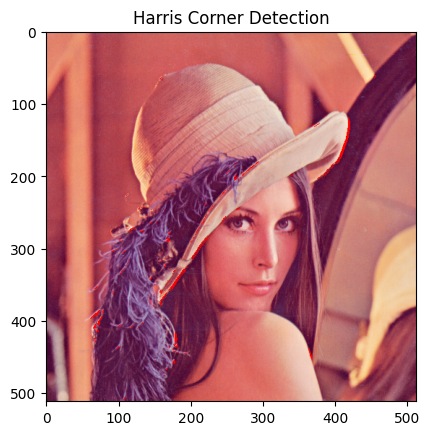

In [7]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Sobel kernels
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) 
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Load the image
#image = cv2.imread('your_image.jpg')
image = cv2.imread('images/lenna.png')

# Sobel filter function from project 1
def sobel_filter(image, kernel_x, kernel_y, padding=0, stride=1):
    # Determine if the image is grayscale or color
    if len(image.shape) == 2:  # Grayscale image
        # Apply padding
        image_padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
        height_image, width_image = image.shape
        
        # Create output matrices for gradients
        gradient_x = np.zeros(((height_image + 2 * padding - kernel_x.shape[0]) // stride + 1, 
                               (width_image + 2 * padding - kernel_x.shape[1]) // stride + 1))
        gradient_y = np.zeros_like(gradient_x)
        
        # Convolve the image with Sobel kernels
        for y in range(gradient_x.shape[0]):
            for x in range(gradient_x.shape[1]):
                region = image_padded[y * stride:y * stride + kernel_x.shape[0], x * stride:x * stride + kernel_x.shape[1]]
                gradient_x[y, x] = np.sum(region * kernel_x)
                gradient_y[y, x] = np.sum(region * kernel_y)
        
        # Compute gradient magnitude
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        gradient_magnitude = cv2.normalize(gradient_magnitude, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        gradient_x = cv2.normalize(gradient_x, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        gradient_y = cv2.normalize(gradient_y, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        
        return gradient_x, gradient_y, gradient_magnitude
    
    else:  # Color image
        channels_x = []
        channels_y = []
        for c in range(image.shape[2]):  # Loop through each channel (R, G, B)
            # Apply padding
            image_padded = np.pad(image[:, :, c], ((padding, padding), (padding, padding)), mode='constant')
            height_image, width_image = image[:, :, c].shape
            
            # Create output matrices for gradients
            gradient_x = np.zeros(((height_image + 2 * padding - kernel_x.shape[0]) // stride + 1, 
                                   (width_image + 2 * padding - kernel_x.shape[1]) // stride + 1))
            gradient_y = np.zeros_like(gradient_x)
            
            # Convolve the image with Sobel kernels for each channel
            for y in range(gradient_x.shape[0]):
                for x in range(gradient_x.shape[1]):
                    region = image_padded[y * stride:y * stride + kernel_x.shape[0], x * stride:x * stride + kernel_x.shape[1]]
                    gradient_x[y, x] = np.sum(region * kernel_x)
                    gradient_y[y, x] = np.sum(region * kernel_y)
            
            # Store gradients for each channel
            channels_x.append(gradient_x)
            channels_y.append(gradient_y)
        
        # Stack the gradients from each channel
        gradient_x = np.stack(channels_x, axis=2)
        gradient_y = np.stack(channels_y, axis=2)
        
        # Compute the gradient magnitude
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        gradient_magnitude = cv2.normalize(gradient_magnitude, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        gradient_x = cv2.normalize(gradient_x, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        gradient_y = cv2.normalize(gradient_y, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        
        return gradient_x, gradient_y, gradient_magnitude


def harris_corner_detector(image, sobel_x, sobel_y, k=0.04, window_size=3, threshold=1e-2):

    # we will convert the image to black and white as corner detection performs better in this form
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)

    # calculating the gradients to detect changes in intensity
    # we will do this using the Sobel filter
    Ix, Iy, _ = sobel_filter(gray, sobel_x, sobel_y)
    Ix = Ix.astype(np.float32)
    Iy = Iy.astype(np.float32)

    # calculating gradient products
    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    Ixy = Ix * Iy  

    # will smooth the products then using the cv2 Gaussian Blur function
    Ix2 = cv2.GaussianBlur(Ix2, (window_size, window_size), 0)
    Iy2 = cv2.GaussianBlur(Iy2, (window_size, window_size), 0)
    Ixy = cv2.GaussianBlur(Ixy, (window_size, window_size), 0)

    # we are not storing the matrix but calculating directly from the eigenvalues
    # calculate eigenvalues
    det_M = (Ix2 * Iy2) - (Ixy ** 2)
    trace_M = Ix2 + Iy2

    # computing Harris response
    R = det_M - k * (trace_M ** 2)

    #thresholding and marking the corners
    corners = R > threshold * R.max()

    # resizing the corners array to match the image dimensions if needed
    # our sobel or gaussian filter could be potentially producing outputs smaller than the input images depending on the kernel size and padding we choose
    if corners.shape != gray.shape:
        corners = cv2.resize(corners.astype(np.uint8), (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_NEAREST).astype(bool)

    harris_image = image.copy()
    harris_image[corners] = [0, 0, 255]  # Mark corners in red

    return harris_image, R


# Apply Harris corner detector
harris_image, response = harris_corner_detector(image, sobel_x, sobel_y)

# Display the result
plt.imshow(cv2.cvtColor(harris_image, cv2.COLOR_BGR2RGB))
plt.title('Harris Corner Detection')
plt.show()

**Questions that must be included in your Report**.

Answer the questions briefly and directly, including the images obtained from the execution of your code to explain your conclusions. Answers must be connected to the executed code.


1. Why is Gaussian smoothing applied to the gradient products $I_x^2$, $I_y^2$ and $I_x I_y$, and what effect does it have on the results?

2. What would happen if the matrix $M$ were structured as:

\begin{equation}
M = \begin{bmatrix}
I_x^2 & 0 \\
0 & I_y^2
\end{bmatrix}
\end{equation}

3. How does the Harris response $R$ reflect the strength of a corner, and what would happen if the threshold value was set too high or too low?

4. What is the significance of the constant $k$ in the Harris response formula, and how would changing its value influence the detection of corners?

5. The Harris Corner Detector:

  A. Is it robust in detecting corners, even in the presence of noise?

  B. Is it not invariant to scale or rotation?

  C. Is it sensitive to changes in illumination?

  D. Does it fail to inherently handle affine transformations, limiting its applicability for tracking features across different perspectives?


# **LoG Blob Detector**

In this exercise, you will implement the Laplacian of Gaussian (LoG)algorithm to identify blobs in images. Follow these steps to complete the implementation of the `detect_blobs_log()` function:

1. Generate LoG Filters: Create scale-normalized Laplacian of Gaussian filters at several scales (different scales means different sigma).

2. Convolve Image: Apply the LoG filters to the image and build a scale-space representation.

3. Find Peaks: Find maxima of squared Laplacian response in scale-space and apply a threshold to filter weak responses.

4. Draw Blobs: Visualise detected blobs with circles corresponding to their scale.

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_blobs_log(image, scales, threshold=0.1):
    # Your code goes here.

# Load the image
image = cv2.imread('images/butterfly.jpg') #, cv2.IMREAD_GRAYSCALE)

# Define the scales (sigma values)
scales = [1.5, 1.7, 2, 6]  # You can adjust these for more resolution at different scales

threshold = 1.8

# Detect blobs using LoG
detect_blobs_log(image, scales, threshold)


IndentationError: expected an indented block after function definition on line 5 (2456515229.py, line 9)

**Questions that must be included in your Report**.

Answer the questions briefly and directly, including the images obtained from the execution of your code to explain your conclusions. Answers must be connected to the executed code.

6. What is the purpose of the Laplacian of Gaussian (LoG) filter in the context of blob detection?

7. How does the sigma value affect the LoG filter, and why is it important to use multiple scales when detecting blobs?

8. LoG Blob Detector:

  A. Is the LoG blob detector robust to noise?

  B. Is the LoG blob detector scale-invariant but not rotation-invariant?

  C. How does the LoG blob detector handle changes in illumination?

  D. Does the LoG blob detector fail to inherently handle affine transformations, limiting its applicability for tracking features across different perspectives?

